In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelBinarizer
import os
import sys
import cv2
from PIL import Image
import ast
import shutil
import random
import time

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import albumentations as A

In [ ]:
print(A.__version__)

1.0.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

train_image = pd.read_csv('/content/drive/MyDrive/train_image_level.csv')
train_study = pd.read_csv('/content/drive/MyDrive/train_study_level.csv')

print(len(train_image))
print(len(train_study))

#### Rename columns

train_study['id'] = train_study['id'].str.replace('_study', '')

train_study.rename(columns={'id': 'StudyInstanceUID'}, inplace=True)

#### Train_result is the final dataframe for training

train_result = train_image.merge(train_study, on='StudyInstanceUID', how='left')

train_result['id'] = train_result['id'].str.replace('_image', '')

#### Add Original dimensions for scaling bboxes

original_dims = pd.read_csv('/content/drive/MyDrive/meta.csv')
original_dims.rename(columns={'image_id': 'id'}, inplace=True)

train_result_final = train_result.merge(original_dims, on='id', how='left')

#### Add extensions to filenames
train_result_final['id'] = train_result_final['id'] + '.jpg'

### Scale bboxes proportionally

train_result_final["boxes"] = train_result_final["boxes"].fillna("[{'x':0, 'y':0, 'width':1, 'height':1}]")
train_result_final["boxes"] = train_result_final["boxes"].apply(lambda x: ast.literal_eval(x))

### Add classes (str and num)

labels_dict = {'Negative for Pneumonia': ["negative", 0], 'Typical Appearance': ["typical", 1], 'Indeterminate Appearance': ["indeterminate", 2], 'Atypical Appearance': ["atypical", 3]}

def convert_and_combine_classes(df):
    for lbl in labels_dict:
        if df[lbl]:
            df['class'] = labels_dict[lbl][0]
            df['class_num'] = labels_dict[lbl][1]
    return df

print("Convertng and combining classes. This will take ~10 secs")
train_result_final = train_result_final.apply(convert_and_combine_classes, axis=1)

### Convert and scale bboxes coordinates

def convert_bboxes_to_pascal_voc(df):
    """ go from xmin,ymin,width,height --> xmin,ymin,xmax,ymax """
    for dictionary in df["boxes"]:
        df["xmin"] = dictionary["x"]
        df["ymin"] = dictionary["y"]
        df["xmax"] = dictionary["x"] + dictionary["width"]
        df["ymax"] = dictionary["y"] + dictionary["height"]
    return df

def scale_bbox_coor(df):
    # if df['class'] != 'negative':
    df['xmin'] *= (1 / df['dim1'])
    df['xmax'] *= (1 / df['dim1'])
    df['ymin'] *= (1 / df['dim0'])
    df['ymax'] *= (1 / df['dim0'])
    return df

print("Unpacking bboxes into separate columns. This will take ~20 secs")
train_result_final = train_result_final.apply(convert_bboxes_to_pascal_voc, axis=1)
train_result_final = train_result_final.apply(scale_bbox_coor, axis=1)

train_result_final = train_result_final.filter(['id', 'xmin', 'ymin', 'xmax', 'ymax', 'class'], axis=1)
print("All bboxes unpacked and scaled")

/content
6334
6054
Convertng and combining classes. This will take ~10 secs
Unpacking bboxes into separate columns. This will take ~20 secs
All bboxes unpacked and scaled


In [ ]:
train_result_final.loc[train_result_final['id'] == 'dc5b7d2810ab.jpg']

,id,xmin,ymin,xmax,ymax,class
5477,dc5b7d2810ab.jpg,0.0,0.0,0.000333,0.000464,negative


In [ ]:
!rm -rf ./train
!rm -rf ./val

!mkdir -p ./train
!mkdir -p ./val

!mkdir -p ./train/negative
!mkdir -p ./train/typical
!mkdir -p ./train/indeterminate
!mkdir -p ./train/atypical

!mkdir -p ./val/negative
!mkdir -p ./val/typical
!mkdir -p ./val/indeterminate
!mkdir -p ./val/atypical

## Copy images to train dataset and move 20% of images from train to valid dataset (and add their names to val_filenames list)

In [ ]:
start_time = time.time()

original_dataset_path = '/content/drive/MyDrive/siim_train_6334_jpg'

i = 0
for _, row in train_result_final.iterrows():
    class_type = row['class']
    source_file_path = os.path.join(original_dataset_path, row['id'])
    dest_file_path = os.path.join('./train', class_type, row['id'])
    shutil.copy(source_file_path, dest_file_path)
    i += 1
    if i % 500 == 0:
      print(f"Copied {i} files")
print(f"Copied all {i} files")
print(f"Took {(time.time() - start_time)/60:.3} minutes")

Copied 500 files
Copied 1000 files
Copied 1500 files


In [ ]:
## Move 20% of images from train to valid dataset (and add their names to val_filenames list)

start_time = time.time()

i = 0
val_filenames = []
for dirpath, dirname, filenames in os.walk('./train'):
    if filenames:
        shuffled_filenames = random.sample(filenames, len(filenames))
        split_name = dirpath.split('/')[-1]
        for filename in shuffled_filenames[int(len(shuffled_filenames)*0.8):]:
            source_filename = os.path.join(dirpath, filename)
            dest_filename = os.path.join('./val', split_name, filename)
            shutil.move(source_filename, dest_filename)
            val_filenames.append(filename)
            i += 1
            if i % 500 == 0:
              print(f"Moved {i} files")
print(f"Moved all {i} files")        
print(f"Took {(time.time() - start_time):.3} seconds")

#### Add a column to train_result_final with split names (train/val)

In [ ]:
for ind, row in train_result_final.iterrows():
    if row['id'] in val_filenames:
        train_result_final.at[ind, 'split'] = 'val'
    else:
        train_result_final.at[ind, 'split'] = 'train'
    

In [ ]:
train_result_final

,id,xmin,ymin,xmax,ymax,class,split
0,000a312787f2.jpg,0.527705,0.169497,0.784909,0.674528,typical,val
1,000c3a3f293f.jpg,0.000000,0.000000,0.000353,0.000431,negative,train
2,0012ff7358bc.jpg,0.586613,0.158236,0.788520,0.631647,typical,train
3,001398f4ff4f.jpg,0.637617,0.619697,0.859112,0.791288,atypical,val
4,001bd15d1891.jpg,0.756622,0.356667,0.951066,0.756667,typical,train
...,...,...,...,...,...,...,...
6329,ffcc6edd9445.jpg,0.000000,0.000000,0.000287,0.000236,negative,train
6330,ffd91a2c4ca0.jpg,0.000000,0.000000,0.000293,0.000357,negative,train
6331,ffd9b6cf2961.jpg,0.231886,0.302378,0.360457,0.657984,typical,train
6332,ffdc682f7680.jpg,0.236328,0.454323,0.391927,0.676752,typical,train


In [ ]:
train_df = train_result_final.loc[train_result_final['split'] == 'train'].reset_index(drop=True)

In [ ]:
train_df

,id,xmin,ymin,xmax,ymax,class,split
0,000c3a3f293f.jpg,0.000000,0.000000,0.000353,0.000431,negative,train
1,0012ff7358bc.jpg,0.586613,0.158236,0.788520,0.631647,typical,train
2,001bd15d1891.jpg,0.756622,0.356667,0.951066,0.756667,typical,train
3,0022227f5adf.jpg,0.608920,0.200199,0.732208,0.357556,indeterminate,train
4,002e9b2128d0.jpg,0.649089,0.308455,0.953776,0.943843,typical,train
...,...,...,...,...,...,...,...
5060,ffcc6edd9445.jpg,0.000000,0.000000,0.000287,0.000236,negative,train
5061,ffd91a2c4ca0.jpg,0.000000,0.000000,0.000293,0.000357,negative,train
5062,ffd9b6cf2961.jpg,0.231886,0.302378,0.360457,0.657984,typical,train
5063,ffdc682f7680.jpg,0.236328,0.454323,0.391927,0.676752,typical,train


In [ ]:
val_df = train_result_final.loc[train_result_final['split'] == 'val'].reset_index(drop=True)

In [ ]:
val_df

,id,xmin,ymin,xmax,ymax,class,split
0,000a312787f2.jpg,0.527705,0.169497,0.784909,0.674528,typical,val
1,001398f4ff4f.jpg,0.637617,0.619697,0.859112,0.791288,atypical,val
2,0023f02ae886.jpg,0.000000,0.000000,0.000351,0.000429,negative,val
3,007cf31356c6.jpg,0.152231,0.580000,0.448635,0.826667,typical,val
4,00b767b49fcd.jpg,0.627437,0.460000,0.886690,0.771667,typical,val
...,...,...,...,...,...,...,...
1264,ff0743bee789.jpg,0.000000,0.000000,0.000409,0.000498,negative,val
1265,ff339bf108b4.jpg,0.178519,0.623942,0.401121,0.822249,atypical,val
1266,ff9f10a24c27.jpg,0.000000,0.000000,0.000333,0.000333,negative,val
1267,ffbeafe30b77.jpg,0.202574,0.522942,0.330293,0.650286,typical,val


### Number and percentage of all classes

In [ ]:
train_df_counts = train_df['class'].value_counts()

In [ ]:
train_df_counts

In [ ]:
train_result_final['class'].value_counts(normalize=True) * 100

typical          47.473950
negative         27.407641
indeterminate    17.492895
atypical          7.625513
Name: class, dtype: float64

typical          47.47 0x

negative         27.40 2x

indeterminate    17.49 3x

atypical          7.62 6x

### Size of augmented train dataset

In [ ]:
augmented_train_set_length = train_df_counts['typical'] + train_df_counts['negative'] * 2 + train_df_counts['indeterminate'] * 3 + train_df_counts['atypical'] * 6

In [ ]:
augmented_train_set_length

10155

In [ ]:
def get_list_of_files(dirname):
    list_of_files = os.listdir(dirname)
    all_files = []
    for file in list_of_files:
        full_path = os.path.join(dirname, file)
        all_files.append(full_path)        
    return all_files

In [ ]:
len(get_list_of_files('./train/atypical/'))

386

### Testing augmentations

In [ ]:
def preprocess_image(filepath):
    image_1d = cv2.imread(filepath)
    image_3d = cv2.cvtColor(image_1d, cv2.COLOR_BGR2RGB)
    image_arr = np.float32(image_3d)
    image_arr /= 255.0
    return image_arr

In [ ]:
image = preprocess_image(atypical_images[4])

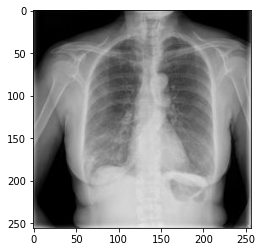

In [ ]:
plt.imshow(image)

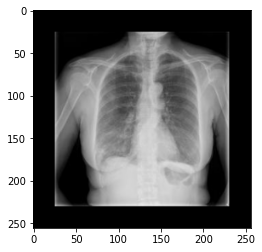

In [ ]:
image_scaled = scale_function_07(image=image, bboxes=bbox_2d, class_labels=class_labels)['image']

plt.imshow(image_scaled)

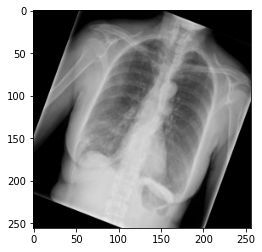

In [ ]:
sheared_image = shear_function(image=image, bboxes=bbox_2d, class_labels=class_labels)['image']

plt.imshow(sheared_image)

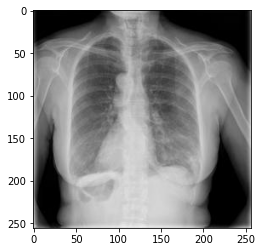

In [ ]:
flipped_image = horizontal_flip_function(image=image, bboxes=bbox_2d, class_labels=class_labels)['image']

plt.imshow(flipped_image)

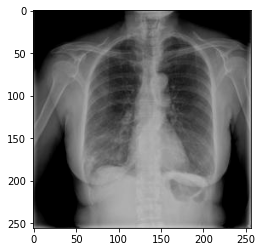

In [ ]:
brightness_contrast_image = brightness_contrast_function(image=image, bboxes=bbox_2d, class_labels=class_labels)['image']

plt.imshow(brightness_contrast_image)

### End of testing section

### Real code

#### We have to perform 1, 2 and 5 augmentations for negative, indeterminate, atypical classes

In [ ]:
bbox_params = A.BboxParams(format='albumentations', min_area=1024, min_visibility=0.5, label_fields=['class_labels'])

scale_function_07 = A.Compose([A.Affine(scale=0.8, p=1)], bbox_params=bbox_params)
scale_move_shear_function = A.Compose([A.Affine(scale=0.95, translate_percent=-0.1, shear=-10, p=1)], bbox_params=bbox_params)
shear_function = A.Compose([A.Affine(shear=20, p=1)], bbox_params=bbox_params)
brightness_contrast_function = A.Compose([A.RandomBrightnessContrast(p=1)], bbox_params=bbox_params)
horizontal_flip_function = A.Compose([A.HorizontalFlip(p=1)], bbox_params=bbox_params)

augmentations = ["scale_function_07", "horizontal_flip_function", "brightness_contrast_function", "shear_function", "scale_move_shear_function"]

def preprocess_image(filepath):
    image_1d = cv2.imread(filepath)
    image_3d = cv2.cvtColor(image_1d, cv2.COLOR_BGR2RGB)
    image_arr = np.float32(image_3d)
    image_arr /= 255.0
    return image_arr

def augment_images_a_num_of_times(function_str, image_arr, bbox, class_labels):
    augmented_image_dict = globals()[function_str](image=image_arr, bboxes=bbox, class_labels=class_labels)
#         print(augmented_image_dict)
    augmented_image = augmented_image_dict['image']
    # If after augmentations our bboxes is outside of the new iamge's boundaries, 
    # we assign it to the negative class (i.e. no opacities are seen within augmented image)
    if augmented_image_dict['bboxes']:
        xmin, ymin, xmax, ymax = augmented_image_dict['bboxes'][0]
        augmented_label = augmented_image_dict['class_labels'][0]
    else:
        xmin, ymin, xmax, ymax = 0, 0, 1/256.0, 1/256.0
        augmented_label = 'negative'
    
    # Improve this!!!
    if class_labels[0] == 'negative':
        xmin, ymin, xmax, ymax = 0, 0, 1/256.0, 1/256.0
        augmented_label = 'negative'

    augmented_label = np.array([augmented_label], dtype='<U16')
    augmented_bbox = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)

    return augmented_image, augmented_bbox, augmented_label

In [ ]:
len(train_df.index)

5065

In [ ]:
classes_to_augments_dict = {'negative': 2, 'indeterminate': 3, 'atypical': 6}

augmented_train_set_length = train_df_counts['typical']
for key, value in classes_to_augments_dict.items():
  augmented_train_set_length += train_df_counts[key] * value

train_images = np.empty((augmented_train_set_length, 256, 256, 3), dtype="float32")
train_bboxes = np.empty((augmented_train_set_length, 4), dtype="float32")
train_labels = np.empty((augmented_train_set_length, 1), dtype='<U16')
train_images_augment_functions = np.empty((augmented_train_set_length, 1), dtype='<U32')

val_images = np.empty((len(val_filenames), 256, 256, 3), dtype="float32")
val_bboxes = np.empty((len(val_filenames), 4), dtype="float32")
val_labels = np.empty((len(val_filenames), 1), dtype='<U16')

splits_to_lists_mapping = {'train': [train_images, train_bboxes, train_labels], 'val': [val_images, val_bboxes, val_labels]}

def create_dataset(df):
  df_len = len(df.index)
  prev_ind = df_len
  for ind, row in df.iterrows():
      row = row.values
      filename = row[0]
      xmin = row[1]
      ymin = row[2]
      xmax = row[3]
      ymax = row[4]
      label = row[5]
      split = row[6]
      filepath = os.path.join('.', split, label, filename)
      image = preprocess_image(filepath)
      bbox = np.array([xmin, ymin, xmax, ymax], dtype=np.float32)

      # Adding original (non-augmented) images from both splits to the dataset
      splits_to_lists_mapping[split][0][ind, :, :, :] = image
      splits_to_lists_mapping[split][1][ind, :] = bbox
      splits_to_lists_mapping[split][2][ind, :] = label

      if label == 'typical':
        continue
      # Adding augmented train images from small labels lists
      if split == 'train':
        if label == 'typical':
        increase_coeff = classes_to_augments_dict[label]
        for i in range(increase_coeff-1):
          # We must feed Python lists to the augemnt functions because we check for truethy/falsy of bbox list and it's not possible with np arrays. 
          # we then convert them into numpy arrays in the functions themselves. 
          class_labels = [label]
          bbox_2d = []
          bbox_2d.append(bbox)
          augmented_image, augmented_bbox, augmented_label = augment_images_a_num_of_times(augmentations[i], image, bbox_2d, class_labels)
          splits_to_lists_mapping[split][0][prev_ind+i, :, :, :] = augmented_image
          splits_to_lists_mapping[split][1][prev_ind+i, :] = augmented_bbox
          splits_to_lists_mapping[split][2][prev_ind+i, :] = augmented_label
          train_images_augment_functions[prev_ind+i, :] = (filename + '_' + augmentations[i].split('_function')[0])
        prev_ind += (i+1)

In [ ]:
start_time = time.time()
create_dataset(train_df)
print(f"Took {(time.time() - start_time):.3} seconds")

Took 12.6 seconds


In [ ]:
start_time = time.time()
create_dataset(val_df)
print(f"Took {(time.time() - start_time):.3} seconds")

Took 1.37 seconds


In [ ]:
train_labels[0]

array(['negative'], dtype='<U16')

#### Check if all labels are correctly added (without empty strings)

In [ ]:
i = 0
train_labels_list = train_labels.tolist()
for ind, lbl in enumerate(train_labels_list):
  if lbl == ['']:
    print(ind)

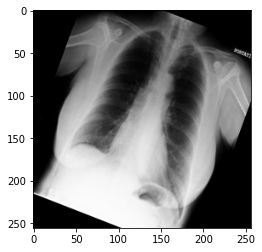

In [ ]:
plt.imshow(train_images[5069])

### One-hot encode labels 

In [ ]:
lb = LabelBinarizer()
lb.fit(["negative", "typical", "indeterminate", "atypical"])
train_labels_onehot = lb.transform(train_labels)     
val_labels_onehot = lb.transform(val_labels)     

In [ ]:
train_labels_onehot[0]

array([0, 0, 1, 0])

In [ ]:
val_labels_onehot[0]

array([0, 0, 0, 1])

## Create model

In [ ]:
base_model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2)
])

flatten = base_model.output
flatten = Flatten()(flatten)

# add dense layers header to predict bounding box coordinates
bbox_head = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(flatten)
bbox_head = Dropout(0.5)(bbox_head)
bbox_head = Dense(64, activation="relu")(bbox_head)
bbox_head = Dropout(0.5)(bbox_head)
bbox_head = Dense(32, activation="relu")(bbox_head)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head)

# bbox_head = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(flatten)
# bbox_head = Dropout(0.5)(bbox_head)
# bbox_head = Dense(512, activation="relu")(bbox_head)
# bbox_head = Dropout(0.5)(bbox_head)
# bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head)

# add dense layers header to predict class labels
label_head = Dense(512, activation="relu")(flatten)
label_head = Dropout(0.5)(label_head)
label_head = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))(label_head)
label_head = Dropout(0.5)(label_head)
label_head = Dense(4, activation="softmax", name="class_label")(label_head)

# accept an input image and output bounding box coordinates and class labels
model = Model(inputs=base_model.input, outputs=(bbox_head, label_head))

In [ ]:
# losses dictionary
losses = {"class_label": "categorical_crossentropy", "bounding_box": "mean_squared_error",}

# weights dictionary
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}

opt = Adam(learning_rate=0.00001)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=loss_weights)

In [ ]:
# train targets dictionary
train_targets = {"class_label": train_labels_onehot, "bounding_box": train_bboxes}

# validation targets dictionary
val_targets = {"class_label": val_labels_onehot, "bounding_box": val_bboxes}

In [ ]:
len(train_images)

10155

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_class_label_accuracy', patience=3, restore_best_weights=True, verbose=1)

In [ ]:
H = model.fit(
    train_images, train_targets,
    validation_data=(val_images, val_targets),
    batch_size=16,
    epochs=20,
    callbacks=[callback],
    verbose=1)

Epoch 1/20
635/635 [==============================] - 73s 113ms/step - loss: 1.4319 - bounding_box_loss: 0.0838 - class_label_loss: 1.3482 - bounding_box_accuracy: 0.4587 - class_label_accuracy: 0.3412 - val_loss: 1.3504 - val_bounding_box_loss: 0.0835 - val_class_label_loss: 1.2669 - val_bounding_box_accuracy: 0.5847 - val_class_label_accuracy: 0.5138
Epoch 2/20
635/635 [==============================] - 72s 113ms/step - loss: 1.3502 - bounding_box_loss: 0.0768 - class_label_loss: 1.2734 - bounding_box_accuracy: 0.4799 - class_label_accuracy: 0.3999 - val_loss: 1.3293 - val_bounding_box_loss: 0.0806 - val_class_label_loss: 1.2487 - val_bounding_box_accuracy: 0.5823 - val_class_label_accuracy: 0.5256
Epoch 3/20
635/635 [==============================] - 72s 114ms/step - loss: 1.3240 - bounding_box_loss: 0.0742 - class_label_loss: 1.2498 - bounding_box_accuracy: 0.4978 - class_label_accuracy: 0.4225 - val_loss: 1.3021 - val_bounding_box_loss: 0.0792 - val_class_label_loss: 1.2228 - val_

In [ ]:
model.save('4_layers_CNN', save_format="h5")

### Use VGG19 model from Keras

In [ ]:
# load the VGG16 network
model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)), classes=4)

# freeze all VGG layers
model.trainable = False

# flatten the max-pooling output of VGG
flatten = model.output
flatten = Flatten()(flatten)

# add dense layers header to predict bounding box coordinates
bbox_head = Dense(128, activation="relu")(flatten)
bbox_head = Dense(64, activation="relu")(bbox_head)
bbox_head = Dense(32, activation="relu")(bbox_head)
bbox_head = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head)

# add a second dense layers head to predict class labels
label_head = Dense(128, activation="relu")(flatten)
label_head = Dropout(0.5)(label_head)
label_head = Dense(64, activation="relu")(label_head)
label_head = Dropout(0.5)(label_head)
label_head = Dense(len(lb.classes_), activation="softmax", name="class_label")(label_head)

# accept an input image and output bounding box coordinates and class labels
model = Model(inputs=model.input, outputs=(bbox_head, label_head))

### Go up to compile the model and train it!

### Save the VGG19 model

In [ ]:
model.save('VGG19', save_format="h5")

### Plot the results

In [ ]:
# plot the total loss, label loss, and bounding box loss
loss_names = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, 20)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(loss_names):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plot_path = os.path.join('.', "losses_2_layers_.png")
plt.savefig(plot_path)
plt.close()

In [ ]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"], label="class_label_accuracy")
plt.plot(N, H.history["val_class_label_accuracy"], label="val_class_label_accuracy")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# save the accuracies plot
plot_path = os.path.join('.', "accuracies_2_layers_.png")
plt.savefig(plot_path)